In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
from scipy.stats import spearmanr
import numpy as np
import gseapy as gp

In [2]:
import warnings
warnings.simplefilter("ignore",FutureWarning)
warnings.simplefilter("ignore",UserWarning)
warnings.simplefilter("ignore",RuntimeWarning)

In [3]:
count_matrix_path = "/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/OMIX002441-01.csv"
tang_metadata_path = "/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/OMIX002441-02.csv"


In [59]:
df = pd.read_csv(count_matrix_path, index_col=0, header=0)
df_transposed = df.T
tang_metadata = pd.read_csv(tang_metadata_path, index_col=0, header=0)

In [60]:
tang_metadata["tissue"].unique()

array(['PTR1', 'PTR2', 'N', 'PTR3', 'PTR4', 'N1', 'N2', 'PTR6', 'M'],
      dtype=object)

In [61]:
tang_adata = sc.AnnData(df_transposed.values)
tang_adata.obs_names = df_transposed.index
tang_adata.var_names = df_transposed.columns


In [62]:
tang_adata.obs = tang_adata.obs.join(tang_metadata['patient'])
tang_adata.obs = tang_adata.obs.join(tang_metadata['NT'])
tang_adata.obs = tang_adata.obs.join(tang_metadata['tissue'])
tang_adata.obs = tang_adata.obs.join(tang_metadata['cell_type'])


In [63]:
tang_adata.obs.loc[tang_adata.obs["tissue"].isin(["PTR1", "PTR2", "PTR3", "PTR4", "PTR5"]), "tissue_type"] = "PT"
tang_adata.obs.loc[tang_adata.obs["tissue"].isin(["N", "N1", "N2"]), "tissue_type"] = "NAT"
tang_adata.obs.loc[tang_adata.obs["tissue"].isin(["M"]), "tissue_type"] = "RT"

In [64]:
# QC
def qc(adata):
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var["mt"]=adata.var_names.str.startswith("MT-")
    adata.var["ribo"]=adata.var_names.str.startswith(("RPS","RPL"))
    adata.var["hb"]=adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata,qc_vars=["mt","ribo","hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ["total_counts_mt","log1p_total_counts_mt","total_counts_ribo","log1p_total_counts_ribo","total_counts_hb","log1p_total_counts_hb"]
    adata.obs=adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [65]:
qc(tang_adata)

AnnData object with n_obs × n_vars = 5025 × 21395
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'tissue_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [66]:
%matplotlib inline

Text(0, 0.5, '% Counts per cell mapping to rRNAs')

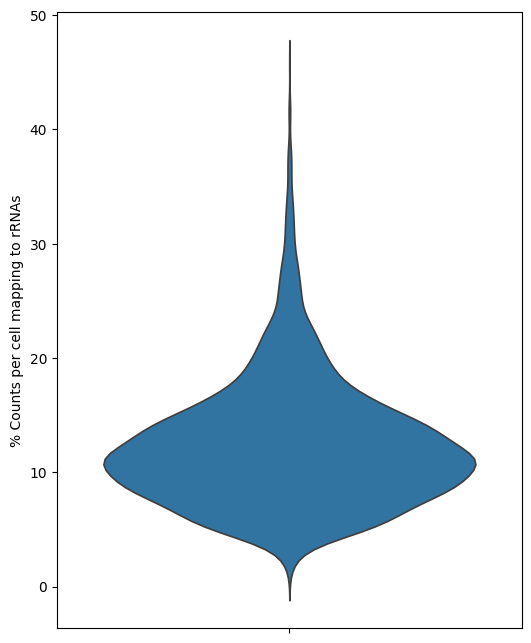

In [67]:
ribo_pct_data = tang_adata.obs['pct_counts_ribo']
plt.figure(figsize=(6, 8))
sns.violinplot(y=ribo_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to rRNAs')

Text(0, 0.5, '% Counts per cell mapping to Hemoglobin genes')

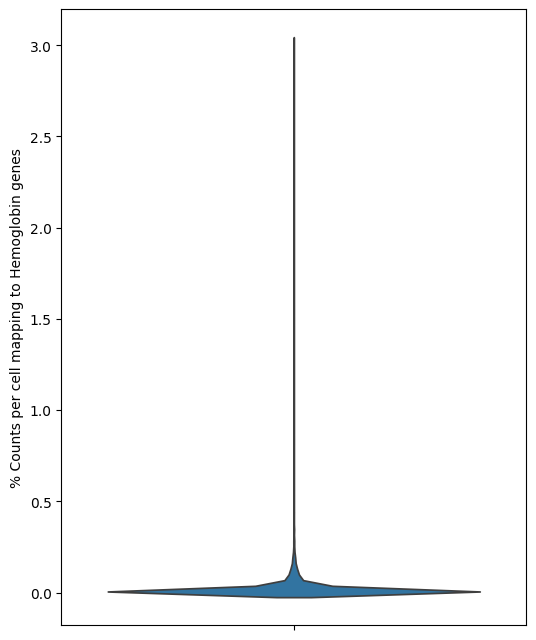

In [68]:
hb_pct_data = tang_adata.obs['pct_counts_hb']
plt.figure(figsize=(6, 8))
sns.violinplot(y=hb_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to Hemoglobin genes')

Text(0, 0.5, '% Counts per cell mapping to Mitochondrial genes')

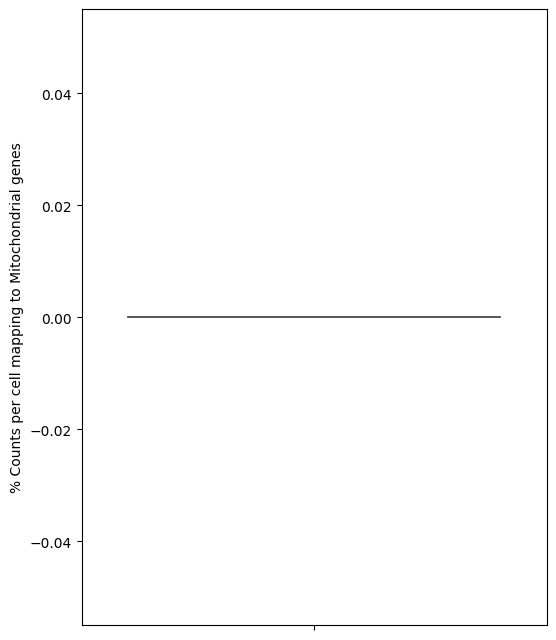

In [69]:
mt_pct_data = tang_adata.obs['pct_counts_mt']
plt.figure(figsize=(6, 8))
sns.violinplot(y=mt_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to Mitochondrial genes')

Text(0, 0.5, 'Number of genes with mapped transcripts per cell')

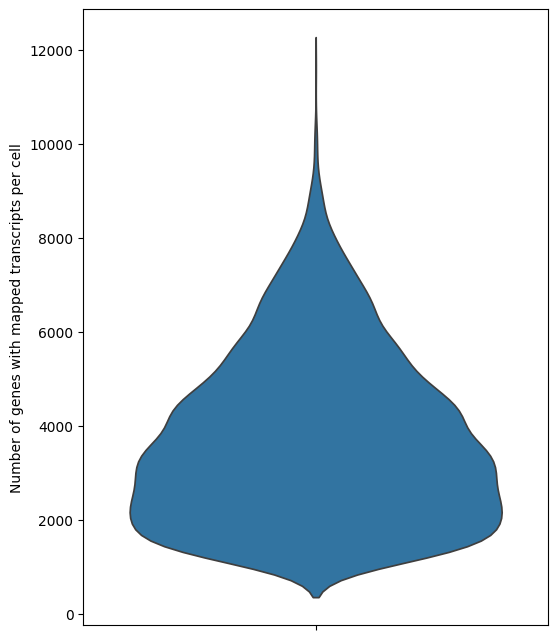

In [70]:
genes_data = tang_adata.obs['n_genes']
plt.figure(figsize=(6, 8))
sns.violinplot(y=genes_data, inner=None)
plt.ylabel('Number of genes with mapped transcripts per cell')

Text(0, 0.5, '% Counts mapped to top 20 genes per cell')

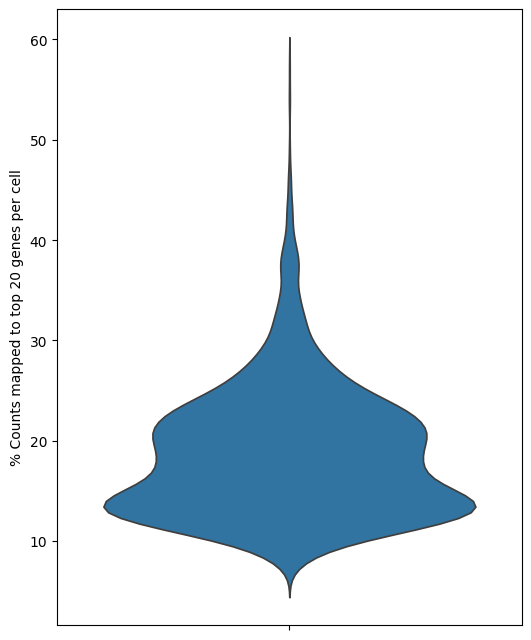

In [71]:
genes_top20_data = tang_adata.obs['pct_counts_in_top_20_genes']
plt.figure(figsize=(6, 8))
sns.violinplot(y=genes_top20_data, inner=None)
plt.ylabel('% Counts mapped to top 20 genes per cell')

Text(0, 0.5, 'Log of number of reads per cell')

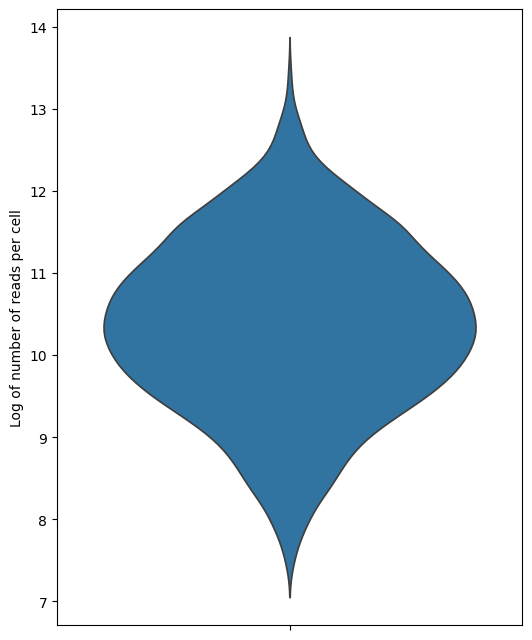

In [72]:
total_counts_data = tang_adata.obs['log1p_total_counts']
plt.figure(figsize=(6, 8))
sns.violinplot(y=total_counts_data, inner=None)
plt.ylabel('Log of number of reads per cell')

In [73]:
a = tang_adata.obs["log1p_total_counts"]

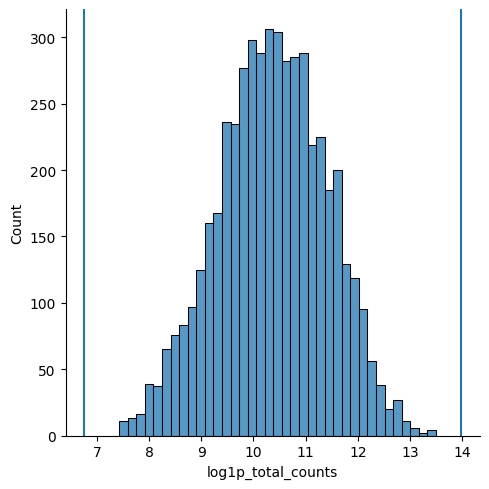

In [74]:
ax = sns.displot(a)
plt.axvline(np.median(a) - 5 * mad(a))
plt.axvline(np.median(a) + 5 * mad(a))
plt.show()

In [75]:
def mad_outlier(adata,metric,nmads,upper_only=False):
    M = adata.obs[metric]

    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    return (M > np.median(M) + nmads * mad(M))

In [76]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25] 
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    return adata

In [77]:
tang_adata_processed = pp(tang_adata)

In [78]:
print(tang_adata_processed.uns["cells_removed"])

52


In [79]:
(tang_adata_processed.obs["tissue_type"] == "RT").sum()

273

In [80]:
sc.pp.scrublet(tang_adata_processed)

In [81]:
tang_adata_processed

AnnData object with n_obs × n_vars = 4973 × 21395
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'tissue_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed', 'scrublet'

In [82]:
tang_adata_processed = tang_adata_processed[tang_adata_processed.obs["predicted_doublet"] != True]

In [83]:
(tang_adata_processed.obs["tissue_type"] == "NAT").sum()

1295

In [84]:
tang_adata_processed.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tang_adata_qc_filtered.h5ad")

In [112]:
NE_genes = ['KIF1A', 'GNAO1','DPYSL5','SYP','CHGA','KIF5C','SCAMP5','TUBB2B','SCG3','GNG4','CRMP1','RUNDC3A','CHRNB2','BEX1','PGBD5','CHGB','RAB39A', 'NCAM1','TMEM198','AP3B2','UNC13A','MAPK8IP1','SNAP25','SOGA3','INSM1']
non_NE_genes = ['HFE','ITGB4','IL18','ANXA3','CAV2','GPRC5A','AHNAK','ADGRG6','IFITM3','CAV1','EPHA2','GPX8','LGALS3','CCN1','RHBDF1','NT5E','WWTR1','NABP1','OSMR','YAP1','TGFBR2','ANXA1','S100A16','MYOF','EMP1']

In [113]:
zhang_ne_gene_sets = {
    'NE': NE_genes,
    'non_NE': non_NE_genes
}

In [114]:
sclc_a_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_a_ccle_degs.txt"
sclc_n_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_n_ccle_degs.txt"
sclc_p_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_p_ccle_degs.txt"


In [115]:
sclc_a_degs = []
sclc_n_degs = []
sclc_p_degs = []


with open(sclc_a_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_a_degs.append(ll)

with open(sclc_n_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_n_degs.append(ll)

with open(sclc_p_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_p_degs.append(ll)

In [116]:
sclc_a_degs.sort()
sclc_n_degs.sort()
sclc_p_degs.sort()
print(sclc_p_degs)

['ACADSB', 'ALDH1A1', 'ALKAL1', 'ANXA1', 'ANXA4', 'ARHGEF35', 'ARHGEF5', 'ASCL2', 'AVIL', 'AZGP1', 'BMX', 'C11orf53', 'C4orf19', 'CD79B', 'CDC42EP1', 'CHRDL1', 'CRYM', 'CTSZ', 'CYRIA', 'EHF', 'EPHB3', 'ETV7', 'FAT3', 'FGF13', 'FOXI1', 'GAS7', 'GFI1B', 'GNG13', 'HES2', 'HLA', 'HMX3', 'HOXC10', 'HOXC12', 'IL13RA1', 'IL17RB', 'IRAG2', 'ITPRID1', 'KAT2B', 'KCNQ1', 'LGALS3', 'MAN1A1', 'MSTN', 'MYMX', 'NMU', 'PIK3R5', 'PITX2', 'PKP3', 'PLA2G4A', 'PLCG2', 'POU2F3', 'PROM2', 'PSD2', 'RBM38', 'RGL1', 'RGS13', 'RHOD', 'SH2D6', 'SOX9', 'SPATS2L', 'SPIB', 'TAMALIN', 'TAP1', 'TFAP2C', 'TRIM58', 'VAV1']


In [117]:
sclc_subtype_gene_sets = {
    'A': sclc_a_degs,
    'N': sclc_n_degs,
    'P':sclc_p_degs
}

In [118]:
tumor_adata_filtered.X

array([[-1.0690055 , -0.18835555, -0.31160584, ..., -0.40426514,
         3.2575915 ,  0.73356104],
       [ 1.1561342 , -0.18835555, -0.31160584, ...,  3.4573252 ,
         0.506561  ,  0.5414273 ],
       [-0.36554223, -0.18835555,  2.5171926 , ...,  3.313519  ,
        -0.35643816,  0.5683312 ],
       ...,
       [ 1.1751328 , -0.18835555, -0.31160584, ...,  1.9030129 ,
        -0.35643816,  0.63276154],
       [-1.0690055 , -0.18835555, -0.31160584, ..., -0.40426514,
        -0.35643816, -1.0569496 ],
       [-1.0690055 , -0.18835555, -0.31160584, ..., -0.40426514,
         2.119716  , -1.0569496 ]], dtype=float32)

In [120]:
tumor_expr_matrix_df = pd.DataFrame(tumor_adata_filtered.X, index=tumor_adata_filtered.obs_names, columns=tumor_adata_filtered.var_names)

In [121]:
gs_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=zhang_ne_gene_sets,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [122]:
gs_subtype_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=sclc_subtype_gene_sets,
    min_size=5,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [123]:
hallmark_myc_v1 = "ABCE1,ACP1,AIMP2,AP3S1,APEX1,BUB3,C1QBP,CAD,CANX,CBX3,CCNA2,CCT2,CCT3,CCT4,CCT5,CCT7,CDC20,CDC45,CDK2,CDK4,CLNS1A,CNBP,COPS5,COX5A,CSTF2,CTPS,CUL1,CYC1,DDX18,DDX21,DEK,DHX15,DUT,EEF1B2,EIF1AX,EIF2S1,EIF2S2,EIF3B,EIF3D,EIF3J,EIF4A1,EIF4E,EIF4G2,EIF4H,EPRS,ERH,ETF1,EXOSC7,FAM120A,FBL,G3BP1,GLO1,GNB2L1,GNL3,GOT2,GSPT1,H2AFZ,HDAC2,HDDC2,HDGF,HNRNPA1,HNRNPA2B1,HNRNPA3,HNRNPC,HNRNPD,HNRNPR,HNRNPU,HPRT1,HSP90AB1,HSPD1,HSPE1,IARS,IFRD1,ILF2,IMPDH2,KARS,KPNA2,KPNB1,LDHA,LSM2,LSM7,MAD2L1,MCM2,MCM4,MCM5,MCM6,MCM7,MRPL23,MRPL9,MRPS18B,MYC,NAP1L1,NCBP1,NCBP2,NDUFAB1,NHP2,NME1,NOLC1,NOP16,NOP56,NPM1,ODC1,ORC2,PA2G4,PABPC1,PABPC4,PCBP1,PCNA,PGK1,PHB,PHB2,POLD2,POLE3,PPIA,PPM1G,PRDX3,PRDX4,PRPF31,PRPS2,PSMA1,PSMA2,PSMA4,PSMA6,PSMA7,PSMB2,PSMB3,PSMC4,PSMC6,PSMD1,PSMD14,PSMD3,PSMD7,PSMD8,PTGES3,PWP1,RAD23B,RAN,RANBP1,RFC4,RNPS1,RPL14,RPL18,RPL22,RPL34,RPL6,RPLP0,RPS10,RPS2,RPS3,RPS5,RPS6,RRM1,RRP9,RSL1D1,RUVBL2,SERBP1,SET,SF3A1,SF3B3,SLC25A3,SMARCC1,SNRPA,SNRPA1,SNRPB2,SNRPD1,SNRPD2,SNRPD3,SNRPG,SRM,SRPK1,SRSF1,SRSF2,SRSF3,SRSF7,SSB,SSBP1,STARD7,SYNCRIP,TARDBP,TCP1,TFDP1,TOMM70A,TRA2B,TRIM28,TUFM,TXNL4A,TYMS,U2AF1,UBA2,UBE2E1,UBE2L3,USP1,VBP1,VDAC1,VDAC3,XPO1,XPOT,XRCC6,YWHAE,YWHAQ"
hallmark_myc_v1 = hallmark_myc_v1.split(",")


In [124]:
myc_gene_sets = {
    'Hallmark_MYC_v1': hallmark_myc_v1
}

In [125]:
gs_myc_res = gp.ssgsea(
    data=tumor_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=myc_gene_sets,
    min_size=5,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [126]:
ssgsea_scores = gs_res.results
ssgsea_subtype_scores = gs_subtype_res.results
ssgsea_myc_scores = gs_myc_res.results

In [127]:
for key in ssgsea_scores.keys():
    print(ssgsea_scores[key])
    break

{'non_NE': {'name': 'SCLC_P10_PTR1_B1_1', 'es': 1608.377986392229, 'nes': 0.1555639970345453, 'pval': 0.0, 'fdr': 0.0, 'fwerp': 0.0, 'tag %': '', 'gene %': '', 'lead_genes': '', 'matched_genes': 'NT5E;YAP1;CAV2;ADGRG6;EPHA2;ITGB4;GPX8;OSMR;IL18;TGFBR2;GPRC5A;MYOF;CAV1;EMP1;ANXA3;WWTR1;RHBDF1;NABP1;S100A16;AHNAK;ANXA1;IFITM3;LGALS3', 'hits': [2578, 2969, 3195, 3241, 3800, 4054, 4203, 4515, 4547, 4628, 5466, 5557, 5823, 6345, 6527, 6574, 7151, 7347, 8379, 9169, 12766, 13526, 13660], 'RES': []}, 'NE': {'name': 'SCLC_P10_PTR1_B1_1', 'es': 657.935955827289, 'nes': 0.06363625214171335, 'pval': 0.0, 'fdr': 0.0, 'fwerp': 0.0, 'tag %': '', 'gene %': '', 'lead_genes': '', 'matched_genes': 'CHGB;CHGA;BEX1;CRMP1;TUBB2B;SCG3;GNG4;CHRNB2;TMEM198;RAB39A;MAPK8IP1;AP3B2;PGBD5;RUNDC3A;SCAMP5;UNC13A;SYP;SOGA3;GNAO1;DPYSL5;KIF5C;INSM1;SNAP25;NCAM1;KIF1A', 'hits': [741, 1580, 1748, 2024, 2040, 2257, 2459, 5372, 6338, 7235, 8028, 8105, 8366, 8385, 8491, 8791, 9431, 10365, 10911, 12784, 13709, 13720, 13967, 

In [128]:
for key in ssgsea_subtype_scores.keys():
    print(ssgsea_subtype_scores[key])
    break

{'N': {'name': 'SCLC_P10_PTR1_B1_1', 'es': 3240.0006565663107, 'nes': 0.3200639797265112, 'pval': 0.0, 'fdr': 0.0, 'fwerp': 0.0, 'tag %': '', 'gene %': '', 'lead_genes': '', 'matched_genes': 'NEFM;DACH1;NEUROD1;MCC;CHRNA1;PRDM8;NUDT11;CERKL;MFAP4;SSTR2;GAP43;SPARC', 'hits': [67, 138, 563, 3060, 4008, 4121, 4535, 4617, 6566, 8248, 9008, 9883], 'RES': []}, 'P': {'name': 'SCLC_P10_PTR1_B1_1', 'es': 1148.878080772337, 'nes': 0.11349210377699336, 'pval': 0.0, 'fdr': 0.0, 'fwerp': 0.0, 'tag %': '', 'gene %': '', 'lead_genes': '', 'matched_genes': 'ALDH1A1;NMU;PLA2G4A;RGS13;CTSZ;SPIB;RHOD;ARHGEF5;GAS7;VAV1;C4orf19;SH2D6;CD79B;ARHGEF35;TRIM58;PIK3R5;PROM2;C11orf53;GFI1B;ASCL2;KCNQ1;TFAP2C;POU2F3;RGL1;KAT2B;FOXI1;AVIL;CDC42EP1;HOXC10;HES2;EPHB3;PKP3;PLCG2;FAT3;ETV7;ACADSB;AZGP1;IL13RA1;MAN1A1;TAP1;SOX9;CRYM;ANXA4;RBM38;SPATS2L;IL17RB;ANXA1;LGALS3;EHF', 'hits': [105, 1063, 2451, 2789, 3170, 3478, 3672, 3775, 3799, 4024, 4088, 4123, 4147, 4319, 4615, 4854, 4984, 5309, 5350, 5382, 5646, 5667, 5822

In [129]:
cell_idx = tumor_adata_filtered.obs_names.get_loc("SCLC_P10_PTR1_B1_1")
gene_idx = tumor_adata_filtered.var_names.get_loc('REST')
expression_value = tumor_adata_filtered.X[cell_idx, gene_idx]
expression_value

-0.36339846

In [130]:
nes_ne = []
nes_non_ne = []
cells = []

for cell_id, result in ssgsea_scores.items():
    cells.append(cell_id)
    nes_ne.append(result['NE']['nes'])
    nes_non_ne.append(result['non_NE']['nes'])  
    
nes_df = pd.DataFrame({
    'NE_ssgsea': nes_ne,
    'non_NE_ssgsea': nes_non_ne
}, index=cells)


In [131]:
sclca = []
sclcn = []
sclcp = []
cells1 = []

for cell_id, result in ssgsea_subtype_scores.items():
    cells1.append(cell_id)
    sclca.append(result['A']['nes'])
    sclcn.append(result['N']['nes'])
    sclcp.append(result['P']['nes'])
    
sclc_subtype_df = pd.DataFrame({
    'A_ssgsea': sclca,
    'N_ssgsea': sclcn,
    'P_ssgsea': sclcp
}, index=cells1)

In [132]:
hallmark_myc = []
cells2 = []

for cell_id, result in ssgsea_myc_scores.items():
    cells2.append(cell_id)
    hallmark_myc.append(result["Hallmark_MYC_v1"]['nes'])
    
sclc_myc_df = pd.DataFrame({
    "Hallmark_MYC_v1_ssgsea": hallmark_myc
}, index=cells2)

In [133]:
for i in range(len(cells)):
    idx = tumor_adata_filtered.obs_names.get_loc(cells[i])
    tumor_adata_filtered.obs.loc[cells[i], 'NE_ssgsea'] = nes_ne[i]
    tumor_adata_filtered.obs.loc[cells[i], 'non_NE_ssgsea'] = nes_non_ne[i]

    idx2 = tumor_adata_filtered.obs_names.get_loc(cells1[i])
    tumor_adata_filtered.obs.loc[cells1[i], 'A_ssgsea'] = sclca[i]
    tumor_adata_filtered.obs.loc[cells1[i], 'N_ssgsea'] = sclcn[i]
    tumor_adata_filtered.obs.loc[cells1[i], 'P_ssgsea'] = sclcp[i]

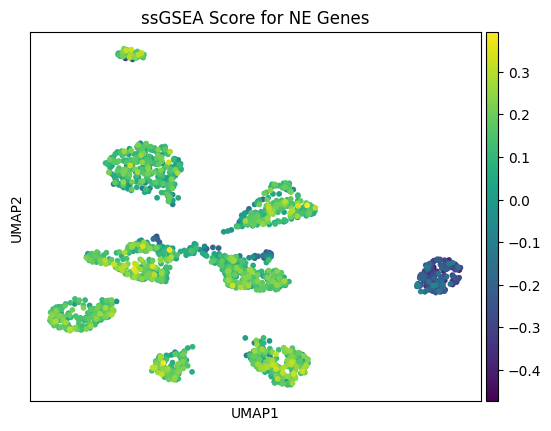

In [134]:
sc.pl.umap(tumor_adata_filtered, color='NE_ssgsea', title='ssGSEA Score for NE Genes')


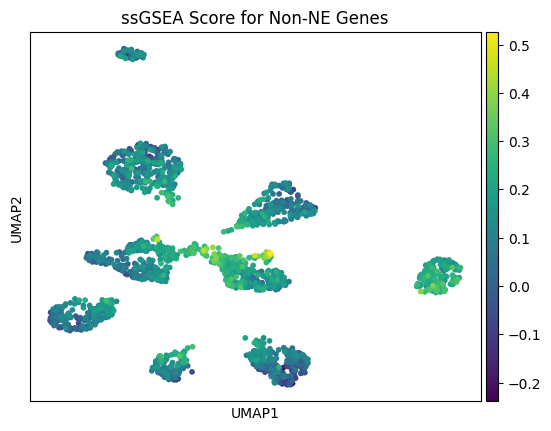

In [135]:
sc.pl.umap(tumor_adata_filtered, color='non_NE_ssgsea', title='ssGSEA Score for Non-NE Genes')


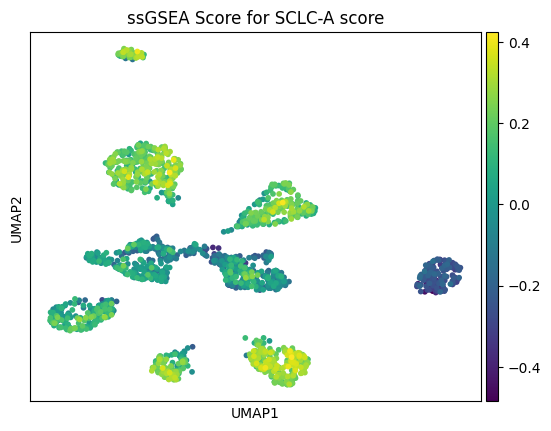

In [136]:
sc.pl.umap(tumor_adata_filtered, color='A_ssgsea', title='ssGSEA Score for SCLC-A score')


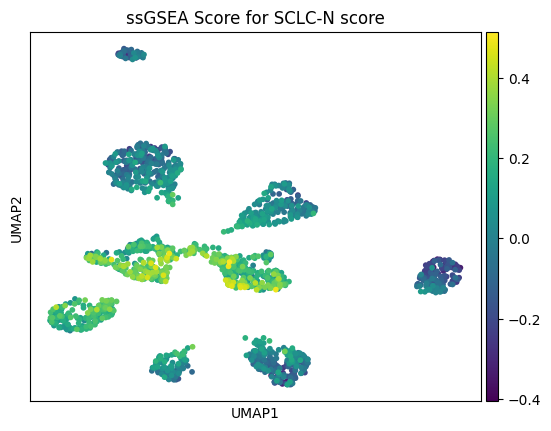

In [137]:
sc.pl.umap(tumor_adata_filtered, color='N_ssgsea', title='ssGSEA Score for SCLC-N score')


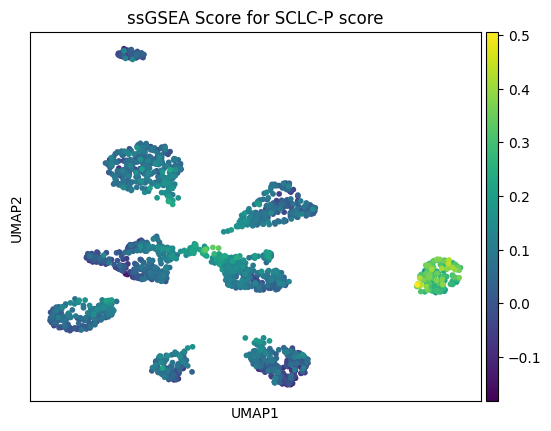

In [138]:
sc.pl.umap(tumor_adata_filtered, color='P_ssgsea', title='ssGSEA Score for SCLC-P score')


In [139]:
# Specify the cell name you want to check
cell_name = "SCLC_P10_PTR1_B1_1"  # Replace with the actual cell you're checking

# Access NE_ssgsea and non_NE_ssgsea values for this specific cell
ne_score = tumor_adata_filtered.obs.loc[cell_name, 'NE_ssgsea']
non_ne_score = tumor_adata_filtered.obs.loc[cell_name, 'non_NE_ssgsea']

# Print the values for this cell
print(f"NE_ssgsea value for {cell_name}: {ne_score}")
print(f"non_NE_ssgsea value for {cell_name}: {non_ne_score}")

NE_ssgsea value for SCLC_P10_PTR1_B1_1: 0.06363625214171335
non_NE_ssgsea value for SCLC_P10_PTR1_B1_1: 0.1555639970345453


In [141]:
ssgsea_cols = ["A_ssgsea", "N_ssgsea", "P_ssgsea"]
tumor_adata_filtered.obs["subtype"] = tumor_adata_filtered.obs[ssgsea_cols].idxmax(axis=1)
tumor_adata_filtered.obs["subtype"] = tumor_adata_filtered.obs["subtype"].str.replace("_ssgsea", "")
print(tumor_adata_filtered.obs["subtype"].value_counts())

subtype
A    865
N    618
P    274
Name: count, dtype: int64


In [142]:
subtype_palette = {"A": "red", "N": "blue", "P": "green"}
subtype_colors = tumor_adata_filtered.obs["subtype"].map(subtype_palette)


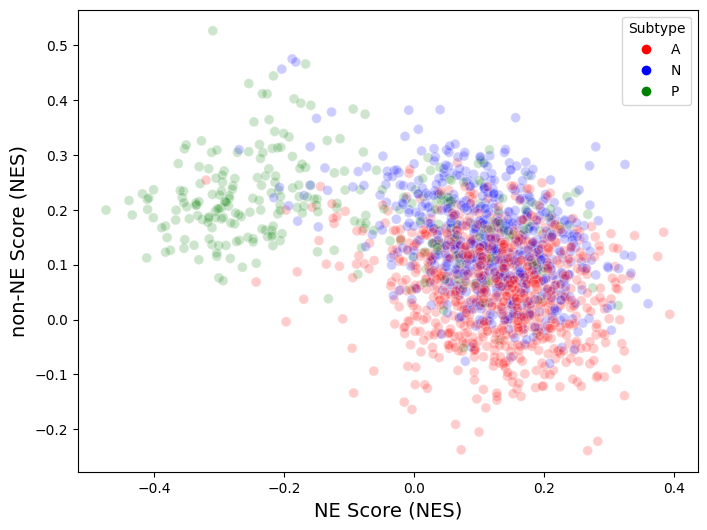

In [143]:
plt.figure(figsize=(8, 6))
plt.scatter(x=tumor_adata_filtered.obs['NE_ssgsea'], y=tumor_adata_filtered.obs['non_NE_ssgsea'], alpha=0.2, edgecolors='w', s=50,c=subtype_colors)

#cell_index = tumor_adata_filtered.obs_names.get_loc("SCLC_P10_PTR1_B1_1")
#plt.scatter(x=tumor_adata_filtered.obs.loc["SCLC_P10_PTR1_B1_1"]["NE_ssgsea"], y=tumor_adata_filtered.obs.loc["SCLC_P10_PTR1_B1_1"]["non_NE_ssgsea"], color='red', s=100, label="SCLC_P10_PTR1_B1_1")

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, 
                             markerfacecolor=color, label=subtype) 
                  for subtype, color in subtype_palette.items()]
plt.legend(handles=legend_handles, title="Subtype", loc="upper right")


plt.xlabel('NE Score (NES)', fontsize=14)
plt.ylabel('non-NE Score (NES)', fontsize=14)
plt.grid(False)
plt.show()

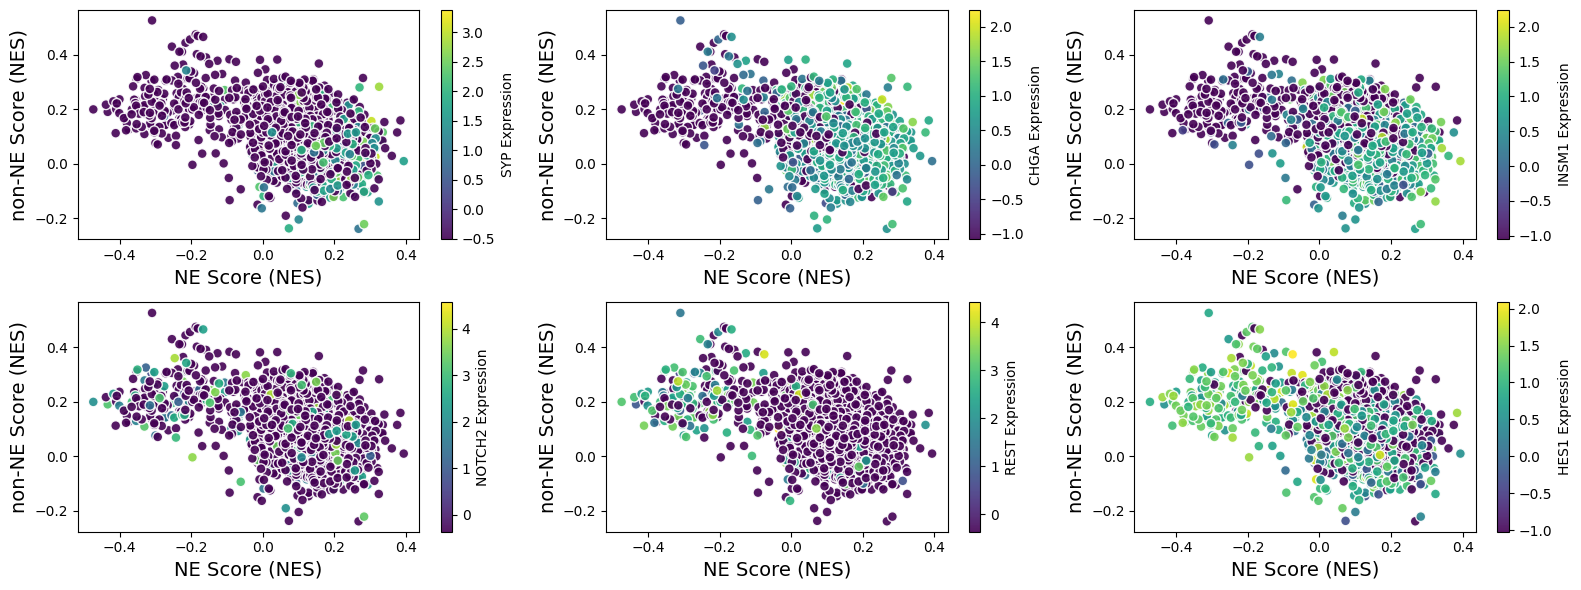

In [144]:
syp_expression = tumor_adata_filtered[:, 'SYP'].X.toarray().flatten()
chga_expression = tumor_adata_filtered[:, 'CHGA'].X.toarray().flatten()
insm1_expression = tumor_adata_filtered[:, 'INSM1'].X.toarray().flatten()
notch2_expression = tumor_adata_filtered[:, 'NOTCH2'].X.toarray().flatten()
rest_expression = tumor_adata_filtered[:, 'REST'].X.toarray().flatten()
hes1_expression = tumor_adata_filtered[:, 'HES1'].X.toarray().flatten()

fig, axes = plt.subplots(2,3, figsize=(16, 6))

# Plot for SYP expression
scatter_syp = axes[0][0].scatter(x=tumor_adata_filtered.obs["NE_ssgsea"], y=tumor_adata_filtered.obs["non_NE_ssgsea"], c=syp_expression, alpha=0.9, edgecolors='w', s=50, cmap='viridis')
axes[0][0].set_xlabel('NE Score (NES)', fontsize=14)
axes[0][0].set_ylabel('non-NE Score (NES)', fontsize=14)
axes[0][0].grid(False)
fig.colorbar(scatter_syp, ax=axes[0][0], label='SYP Expression')

# Plot for CHGA expression
scatter_chga = axes[0][1].scatter(x=tumor_adata_filtered.obs["NE_ssgsea"], y=tumor_adata_filtered.obs["non_NE_ssgsea"], c=chga_expression, alpha=0.9, edgecolors='w', s=50, cmap='viridis')
axes[0][1].set_xlabel('NE Score (NES)', fontsize=14)
axes[0][1].set_ylabel('non-NE Score (NES)', fontsize=14)
axes[0][1].grid(False)
fig.colorbar(scatter_chga, ax=axes[0][1], label='CHGA Expression')

# Plot for INSM1 expression
scatter_insm1 = axes[0][2].scatter(x=tumor_adata_filtered.obs["NE_ssgsea"], y=tumor_adata_filtered.obs["non_NE_ssgsea"], c=insm1_expression, alpha=0.9, edgecolors='w', s=50, cmap='viridis')
axes[0][2].set_xlabel('NE Score (NES)', fontsize=14)
axes[0][2].set_ylabel('non-NE Score (NES)', fontsize=14)
axes[0][2].grid(False)
fig.colorbar(scatter_insm1, ax=axes[0][2], label='INSM1 Expression')

# Plot for NOTCH2 expression
scatter_notch2 = axes[1][0].scatter(x=tumor_adata_filtered.obs["NE_ssgsea"], y=tumor_adata_filtered.obs["non_NE_ssgsea"], c=notch2_expression, alpha=0.9, edgecolors='w', s=50, cmap='viridis')
axes[1][0].set_xlabel('NE Score (NES)', fontsize=14)
axes[1][0].set_ylabel('non-NE Score (NES)', fontsize=14)
axes[1][0].grid(False)
fig.colorbar(scatter_notch2, ax=axes[1][0], label='NOTCH2 Expression')

# Plot for REST expression
scatter_rest = axes[1][1].scatter(x=tumor_adata_filtered.obs["NE_ssgsea"], y=tumor_adata_filtered.obs["non_NE_ssgsea"], c=rest_expression, alpha=0.9, edgecolors='w', s=50, cmap='viridis')
axes[1][1].set_xlabel('NE Score (NES)', fontsize=14)
axes[1][1].set_ylabel('non-NE Score (NES)', fontsize=14)
axes[1][1].grid(False)
fig.colorbar(scatter_rest, ax=axes[1][1], label='REST Expression')

# Plot for HES1 expression
scatter_hes1 = axes[1][2].scatter(x=tumor_adata_filtered.obs["NE_ssgsea"], y=tumor_adata_filtered.obs["non_NE_ssgsea"], c=hes1_expression, alpha=0.9, edgecolors='w', s=50, cmap='viridis')
axes[1][2].set_xlabel('NE Score (NES)', fontsize=14)
axes[1][2].set_ylabel('non-NE Score (NES)', fontsize=14)
axes[1][2].grid(False)
fig.colorbar(scatter_hes1, ax=axes[1][2], label='HES1 Expression')

plt.tight_layout() 
plt.show()

In [145]:
tumor_adata_filtered = tumor_adata_filtered[tumor_adata_filtered.obs["subtype"] != "P"].copy()
print(tumor_adata_filtered.obs["subtype"].value_counts())


subtype
A    865
N    618
Name: count, dtype: int64


In [146]:
subtype_colors = tumor_adata_filtered.obs["subtype"].map(subtype_palette)


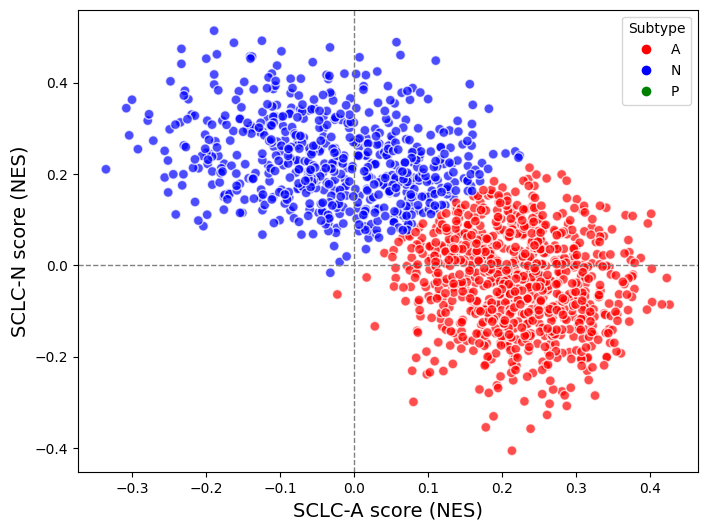

In [147]:
plt.figure(figsize=(8, 6))
plt.scatter(x=tumor_adata_filtered.obs['A_ssgsea'], y=tumor_adata_filtered.obs['N_ssgsea'], alpha=0.7, edgecolors='w', s=50,c=subtype_colors)

x_min, x_max = plt.xlim()  # Get current x-axis limits
y_min, y_max = plt.ylim()  # Get current x-axis limits
#cell_index = tumor_adata_filtered.obs_names.get_loc("SCLC_P10_PTR1_B1_1")
#plt.scatter(x=tumor_adata_filtered.obs.loc["SCLC_P10_PTR1_B1_1"]["NE_ssgsea"], y=tumor_adata_filtered.obs.loc["SCLC_P10_PTR1_B1_1"]["non_NE_ssgsea"], color='red', s=100, label="SCLC_P10_PTR1_B1_1")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Horizontal line (y=0)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, 
                             markerfacecolor=color, label=subtype) 
                  for subtype, color in subtype_palette.items()]
plt.legend(handles=legend_handles, title="Subtype", loc="upper right")

plt.xlabel('SCLC-A score (NES)', fontsize=14)
plt.ylabel('SCLC-N score (NES)', fontsize=14)
plt.grid(False)
plt.show()

In [148]:
# Trajectory analysis with Diffusion Pseudotime in scanpy
# set the cell with highest NE score as the root cell
highest_sclca_cell = tumor_adata_filtered.obs['A_ssgsea'].idxmax()
tumor_adata_filtered.uns['iroot'] = np.where(tumor_adata_filtered.obs.index == highest_sclca_cell)[0][0]

In [149]:
sc.tl.diffmap(tumor_adata_filtered)
sc.tl.dpt(tumor_adata_filtered)


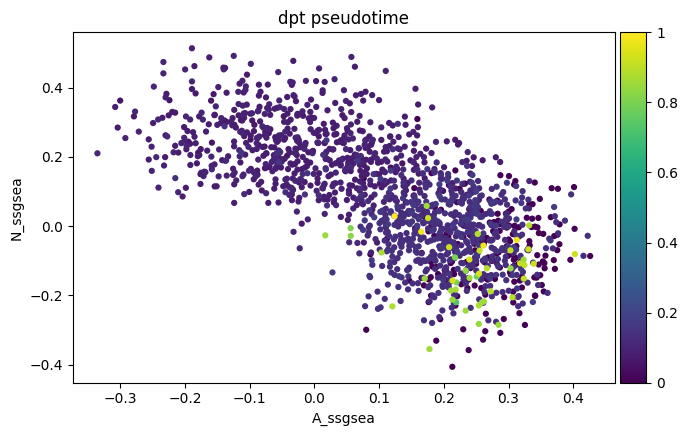

In [150]:
sc.pl.scatter(tumor_adata_filtered, x='A_ssgsea', y='N_ssgsea', color='dpt_pseudotime')


In [151]:
tumor_df_dpt_ordered = tumor_adata_filtered.obs.sort_values("dpt_pseudotime")
pseudotime = tumor_df_dpt_ordered["dpt_pseudotime"]
a_score = tumor_df_dpt_ordered["A_ssgsea"].rolling(window=20, center=True).mean()
n_score = tumor_df_dpt_ordered["N_ssgsea"].rolling(window=20, center=True).mean()

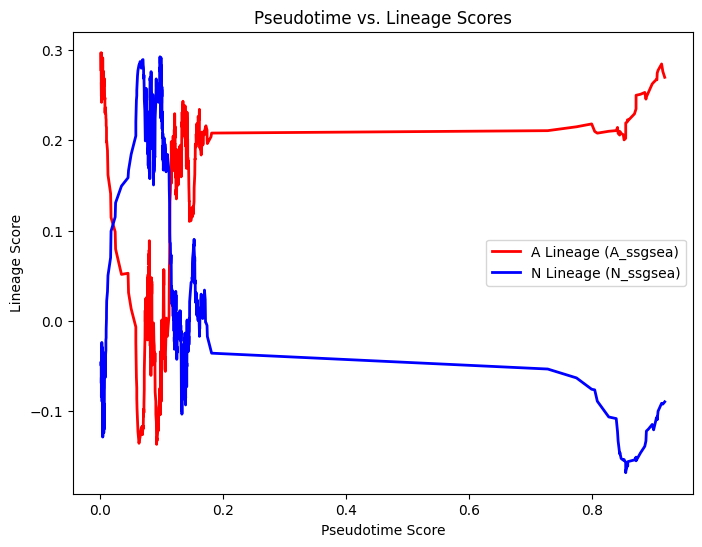

In [152]:
plt.figure(figsize=(8,6))
plt.plot(pseudotime, a_score, label="A Lineage (A_ssgsea)", color="red", linewidth=2)
plt.plot(pseudotime, n_score, label="N Lineage (N_ssgsea)", color="blue", linewidth=2)

# Labels and title
plt.xlabel("Pseudotime Score")
plt.ylabel("Lineage Score")
plt.title("Pseudotime vs. Lineage Scores")
plt.legend()

plt.show()

In [353]:
# Get gene expression matrix and pseudotime values
expr_matrix = tumor_adata_filtered.X  # Gene expression matrix (cells x genes)
pseudotime = tumor_adata_filtered.obs["dpt_pseudotime"]  # Pseudotime values

# Compute correlation of each gene with pseudotime
gene_names = tumor_adata_filtered.var_names
correlations = []
p_values = []

for i, gene in enumerate(gene_names):
    gene_expr = expr_matrix[:, i].flatten()  # Convert sparse matrix to dense
    corr, pval = spearmanr(gene_expr, pseudotime)  # Spearman correlation
    correlations.append(corr)
    p_values.append(pval)

# Create a DataFrame with correlation results
diff_expr_df = pd.DataFrame({
    "gene": gene_names,
    "spearman_corr": correlations,
    "p_value": p_values
})

# Adjust p-values for multiple testing using Benjamini-Hochberg correction
from statsmodels.stats.multitest import multipletests
diff_expr_df["p_adj"] = multipletests(diff_expr_df["p_value"], method="fdr_bh")[0]

# Filter significantly upregulated and downregulated genes
threshold = 0.05  # Significance threshold
upregulated_genes = diff_expr_df[(diff_expr_df["spearman_corr"] > 0) & (diff_expr_df["p_adj"] == True)]
downregulated_genes = diff_expr_df[(diff_expr_df["spearman_corr"] < 0) & (diff_expr_df["p_adj"] == True)]

# Display top upregulated and downregulated genes
print("Top Upregulated Genes:\n", upregulated_genes.sort_values("spearman_corr", ascending=False).head(10))
print("\nTop Downregulated Genes:\n", downregulated_genes.sort_values("spearman_corr").head(10))


Top Upregulated Genes:
           gene  spearman_corr        p_value  p_adj
10880    RPL31       0.609183  1.100712e-179   True
2838     CRIP1       0.607752  1.260278e-178   True
254      ADIRF       0.583383  2.169092e-161   True
5202     GSTP1       0.515615  2.078766e-120   True
9612      PLS3       0.508295  1.621890e-116   True
5132      GPX2       0.504692  1.234491e-114   True
3734       EHF       0.491735  4.723246e-108   True
11518   SIGIRR       0.485816  3.875616e-105   True
6445     KRT19       0.479173  6.183297e-102   True
11191  SCGB3A2       0.463185   1.645184e-94   True

Top Downregulated Genes:
          gene  spearman_corr        p_value  p_adj
7638     MEG3      -0.656079  1.235912e-217   True
9273    PEG10      -0.591406  6.660966e-167   True
3357     DLK1      -0.552574  1.376101e-141   True
8681    NR2F1      -0.534453  7.102733e-131   True
9966      PRL      -0.494637  1.676334e-109   True
4492     FGL1      -0.475237  4.526700e-100   True
11533    SIM1      -

In [354]:
diff_expr_df

,gene,spearman_corr,p_value,p_adj
0,A1BG,0.010440,6.612420e-01,False
1,A2M,0.044911,5.931049e-02,False
2,A4GALT,0.151107,1.786362e-10,True
3,AAAS,0.055624,1.947166e-02,True
4,AACS,0.160489,1.203782e-11,True
...,...,...,...,...
15080,ZYG11A,0.070847,2.909031e-03,True
15081,ZYG11B,0.003589,8.802645e-01,False
15082,ZYX,-0.042800,7.231241e-02,False
15083,ZZEF1,0.002962,9.010572e-01,False


In [365]:
upregulated_genes_sorted = upregulated_genes.sort_values("spearman_corr", ascending=False)
downregulated_genes_sorted = downregulated_genes.sort_values("spearman_corr", ascending=True)

In [370]:
top_300_upregulated_genes = upregulated_genes_sorted.head(300)
top_300_upregulated_genes["gene"].to_csv("top_300_upregulated_genes.txt", index=False, header=False)


In [377]:
top_100_downregulated_genes = downregulated_genes_sorted.head(100)
top_100_downregulated_genes["gene"].to_csv("top_100_downregulated_genes.txt", index=False, header=False)

In [373]:
top_300_upregulated_genes

,gene,spearman_corr,p_value,p_adj
10880,RPL31,0.609183,1.100712e-179,True
2838,CRIP1,0.607752,1.260278e-178,True
254,ADIRF,0.583383,2.169092e-161,True
5202,GSTP1,0.515615,2.078766e-120,True
9612,PLS3,0.508295,1.621890e-116,True
...,...,...,...,...
4593,FOSB,0.276316,2.794292e-32,True
11860,SLIRP,0.276152,3.048414e-32,True
11980,SNAPIN,0.276125,3.093041e-32,True
2492,CKLF,0.275983,3.334765e-32,True


In [378]:
top_100_downregulated_genes

,gene,spearman_corr,p_value,p_adj
7638,MEG3,-0.656079,1.235912e-217,True
9273,PEG10,-0.591406,6.660966e-167,True
3357,DLK1,-0.552574,1.376101e-141,True
8681,NR2F1,-0.534453,7.102733e-131,True
9966,PRL,-0.494637,1.676334e-109,True
...,...,...,...,...
10630,RGS7,-0.265490,7.682474e-30,True
1922,CCDC181,-0.263839,1.768822e-29,True
14267,XCL2,-0.262467,3.521762e-29,True
9731,POMC,-0.262418,3.610795e-29,True
